In [4]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import itertools
%matplotlib inline
# import wrf

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature


# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap

In [5]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [21]:
## iterate through options
varname_lst = ['700z', 'ivt']
ssn_lst = ['DJF', 'MAM', 'JJA', 'SON', 'NDJFMA', 'MJJASO']

tmp_lst = []
for i, varname in enumerate(varname_lst):  
    ds_lst = []
    for j, ssn in enumerate(ssn_lst):
        ## load non-anomaly composite data
        path = '/home/dnash/DATA/preprocessed/ERA5_composites/'
        fname = path + '{0}/baja/composite_{0}_{1}.nc'.format(varname, ssn)
    
        ds = xr.open_dataset(fname)
        ds_lst.append(ds)

    ## concat ds_lst along ssn
    tmp = xr.concat(ds_lst, pd.Index(ssn_lst, name="ssn"))
    tmp_lst.append(tmp)

## merge two datasets
ds4 = xr.merge(tmp_lst)
ds4

<xarray.Dataset>
Dimensions:    (longitude: 401, latitude: 201, ssn: 6)
Coordinates:
  * longitude  (longitude) float32 -170.0 -169.8 -169.5 ... -70.5 -70.25 -70.0
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 10.5 10.25 10.0
  * ssn        (ssn) object 'DJF' 'MAM' 'JJA' 'SON' 'NDJFMA' 'MJJASO'
Data variables:
    z          (ssn, latitude, longitude) float32 2.747e+04 ... 3.093e+04
    ivtv       (ssn, latitude, longitude) float32 58.29 58.62 ... 61.85 96.97
    ivtu       (ssn, latitude, longitude) float32 -3.715 -3.52 ... -121.3 -129.4
    ivt        (ssn, latitude, longitude) float32 107.0 107.1 ... 153.7 177.7

In [32]:
# Set up projection
# mapcrs = ccrs.Mercator()
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
lats = ds.latitude.values
lons = ds.longitude.values
dx = np.arange(lons.min().round(),lons.max().round()+20,20)
dy = np.arange(lats.min().round(),lats.max().round()+10,10)

ext = [-140., -90., 20, 50]

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

271.7543 317.08948
281.73456 316.5594
293.25104 321.05295
284.60376 318.93088


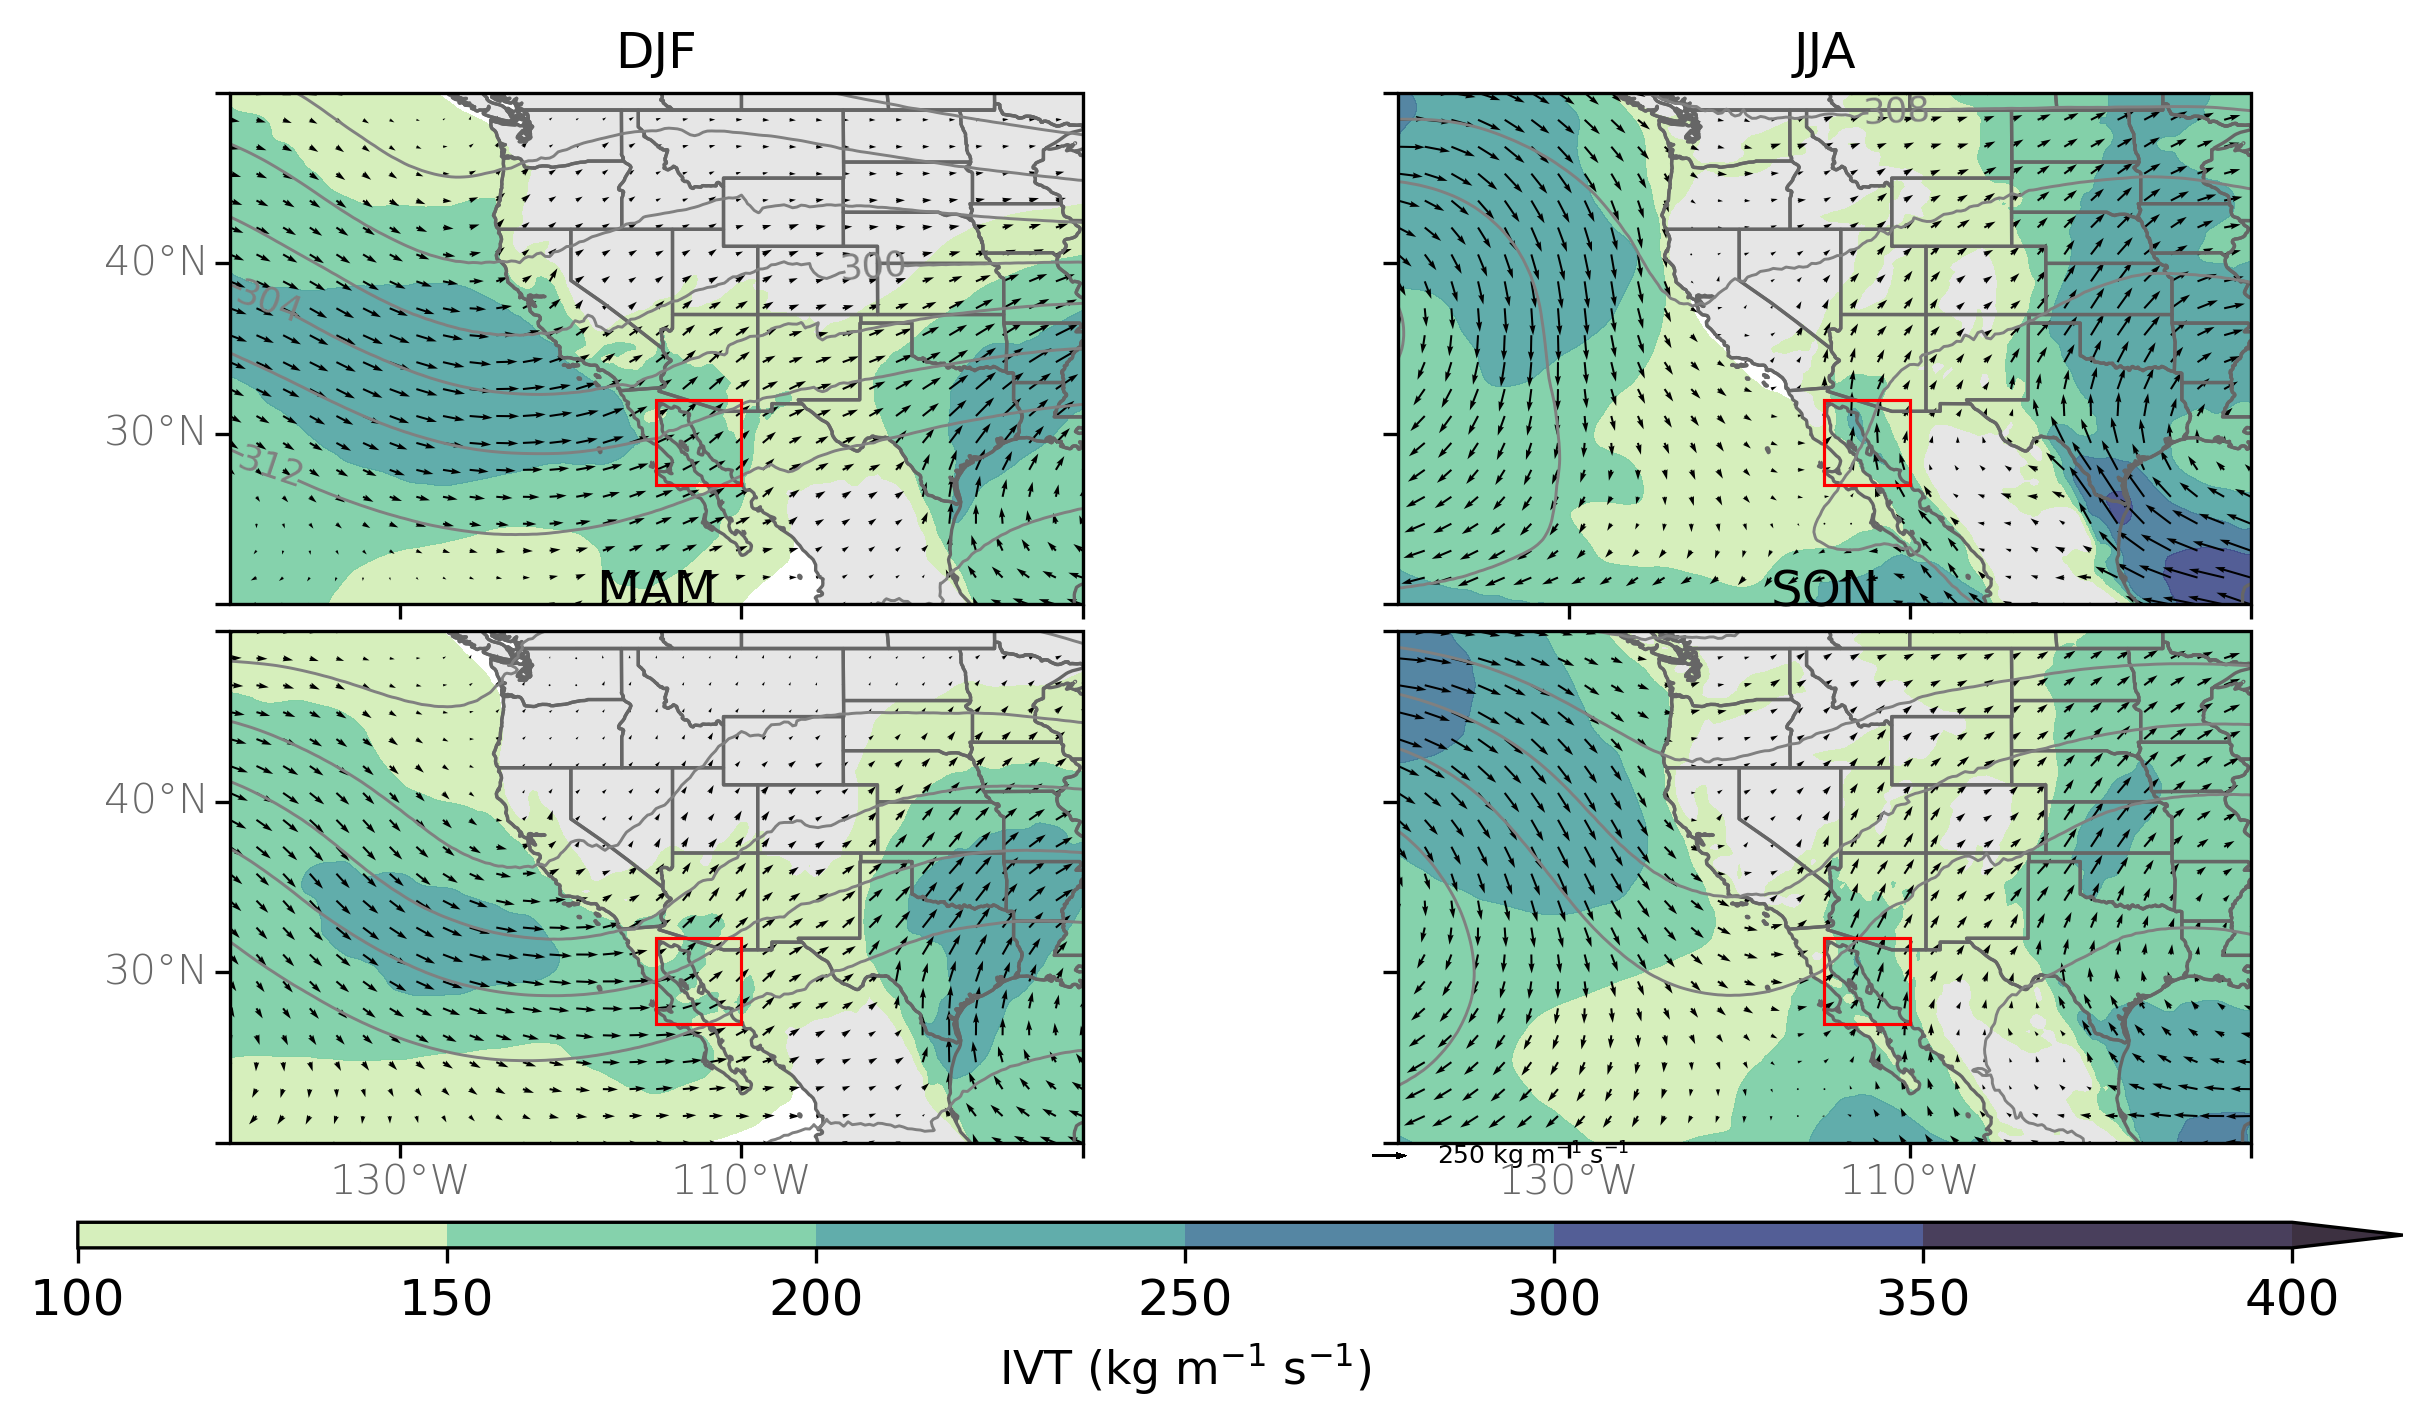

In [33]:
# Create figure
fig = plt.figure(figsize=(10, 5))
fig.dpi = 300
fname = path_to_figs + 'baja_IVT_700z_composite_ssn'
fmt = 'png'

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

nrows = 4
ncols = 2

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 0.05, 0.05], width_ratios = [1, 1], wspace=0.01, hspace=0.1)
## use gs[rows index, columns index] to access grids

#################
### COMPOSITE ###
#################

rowidx = [0, 1, 0, 1]
colidx = [0, 0, 1, 1]
ssn_lst = ['DJF', 'MAM', 'JJA', 'SON']
llats = [True, True, False, False]
blons = [False, True, False, True]
for i, ssn in enumerate(ssn_lst):
    ds = ds4.sel(ssn=ssn)
    ax = fig.add_subplot(gs[rowidx[i], colidx[i]], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=llats[i], right_lats=False, bottom_lons=blons[i])
    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
    ax.set_title(ssn)
    
    # Contour Filled
    lats = ds.latitude.values
    lons = ds.longitude.values
    ivt = ds.ivt.values
    cflevs = np.arange(100, 450, 50) # levels for IVT
    cmap = cmo.deep # cmap for IVT
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')

    # Wind barbs / vectors 
    uvec = ds.ivtu.values
    vvec = ds.ivtv.values
    # uvec_mask = ds.IVTu.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1
    # vvec_mask = ds.IVTv.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1

    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
              color='k', regrid_shape=20,
              angles='xy', scale_units='xy', scale=125, units='xy')

    # Contour Lines
    hgts = ds.z.values/9.80665 ## convert to geopotential height
    hgts = hgts/(10) # convert to meters # 750-hPa Heights
    print(hgts.min(), hgts.max())
    clevs = np.arange(0, 1280, 4)
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='grey', linewidths=0.7)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)



    ext3 = [-115., -110., 27., 32.]
    ax.add_patch(mpatches.Rectangle(xy=[ext3[0], ext3[2]], width=ext3[1]-ext3[0], height=ext3[3]-ext3[2],
                                        fill=False,
                                        edgecolor='r',
                                        linewidth=0.75,
                                        transform=datacrs,
                                        zorder=199))

# quiver key
qk = ax.quiverkey(Q, 0.01, -0.025, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 6.0})
# Colorbar (single)
cbax = plt.subplot(gs[-1,:]) # colorbar axis
cb = fig.colorbar(cf, cbax, orientation='horizontal', drawedges=False)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()

275.29114 316.70804
288.2424 319.31155


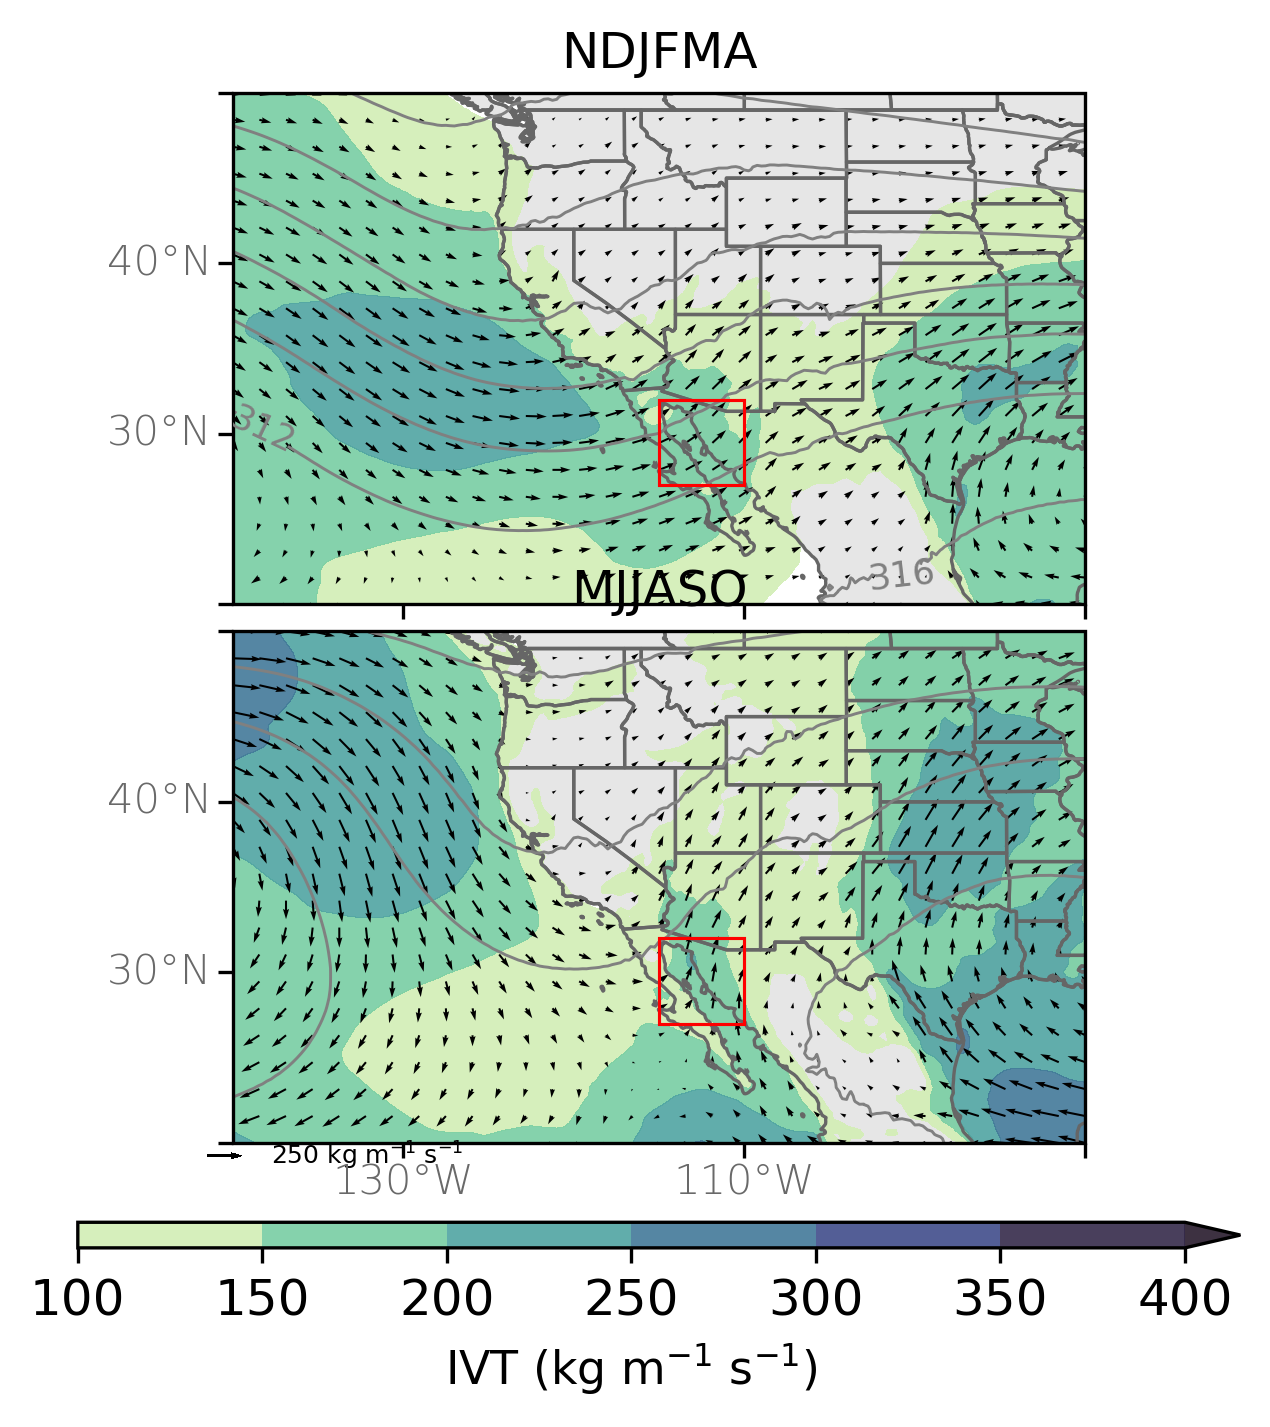

In [34]:
# Create figure
fig = plt.figure(figsize=(5, 5))
fig.dpi = 300
fname = path_to_figs + 'baja_IVT_700z_composite_coolwarm'
fmt = 'png'

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

nrows = 4
ncols = 1

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 0.05, 0.05], width_ratios = [1], wspace=0.01, hspace=0.1)
## use gs[rows index, columns index] to access grids

#################
### COMPOSITE ###
#################

rowidx = [0, 1, 0, 1]
colidx = [0, 0, 1, 1]
ssn_lst = ['NDJFMA', 'MJJASO']
llats = [True, True]
blons = [False, True]
for i, ssn in enumerate(ssn_lst):
    ds = ds4.sel(ssn=ssn)
    ax = fig.add_subplot(gs[rowidx[i], colidx[i]], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=llats[i], right_lats=False, bottom_lons=blons[i])
    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
    ax.set_title(ssn)
    
    # Contour Filled
    lats = ds.latitude.values
    lons = ds.longitude.values
    ivt = ds.ivt.values
    cflevs = np.arange(100, 450, 50) # levels for IVT
    cmap = cmo.deep # cmap for IVT
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')

    # Wind barbs / vectors 
    uvec = ds.ivtu.values
    vvec = ds.ivtv.values
    # uvec_mask = ds.IVTu.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1
    # vvec_mask = ds.IVTv.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1

    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
              color='k', regrid_shape=20,
              angles='xy', scale_units='xy', scale=125, units='xy')

    # Contour Lines
    hgts = ds.z.values/9.80665 ## convert to geopotential height
    hgts = hgts/(10) # convert to meters # 750-hPa Heights
    print(hgts.min(), hgts.max())
    clevs = np.arange(0, 1280, 4)
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='grey', linewidths=0.7)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)



    ext3 = [-115., -110., 27., 32.]
    ax.add_patch(mpatches.Rectangle(xy=[ext3[0], ext3[2]], width=ext3[1]-ext3[0], height=ext3[3]-ext3[2],
                                        fill=False,
                                        edgecolor='r',
                                        linewidth=0.75,
                                        transform=datacrs,
                                        zorder=199))

# quiver key
qk = ax.quiverkey(Q, 0.01, -0.025, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 6.0})
# Colorbar (single)
cbax = plt.subplot(gs[-1,:]) # colorbar axis
cb = fig.colorbar(cf, cbax, orientation='horizontal', drawedges=False)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()